## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [20]:
# from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from itertools import groupby
from itertools import product

In [21]:
class TicTacToe:
    
    def __init__(self):
        """initialise the board"""
        self.state = [0 for _ in range(9)]  # initialises the board position, can initialise to an array or matrix
        self.all_possible_numbers = list(range(1, 10))
        self.reset()
        
    def is_winning(self, curr_state):
        """Takes state as an input and returns whether any row, column or diagonal has winning sum
        Example: Input state = [1, 2, 3, 4, nan, nan, nan, nan, nan]
                 Output = False"""
        board = np.array(curr_state).reshape((3,3))
        diag1 = [board[i, i] for i in range(3)]
        diag2 = [board[i, 3-1-i] for i in range(3)]
        diag1_win = False if 0 in diag1 else sum(diag1)==15
        diag2_win = False if 0 in diag2 else sum(diag2)==15
        for i in range(3):
            row_win = False if 0 in board[i, :] else sum(board[i, :])==15
            col_win = False if 0 in board[:, i] else sum(board[:, i])==15
            if row_win or col_win or diag1_win or diag2_win:
                return True
        return False
    
    def is_terminal(self, curr_state):
        "Terminal state could be winning state or when the board is filled up"
        if self.is_winning(curr_state) == True:
            return True, 'Win'
        elif len(self.allowed_positions(curr_state)) ==0:
            return True, 'Tie'
        else:
            return False, 'Resume'
        
    def allowed_positions(self, curr_state):
        """Takes state as an input and returns all indexes that are blank or 0"""
        return [i for i, val in enumerate(curr_state) if val==0]
    
    def allowed_values(self, curr_state):
        """Takes the current state as input and returns all possible (unused) values that can be placed on the board"""
        used_values = [val for val in curr_state if not val==0]
        agent_values = [val for val in self.all_possible_numbers if val not in used_values and val % 2 !=0]
        env_values = [val for val in self.all_possible_numbers if val not in used_values and val % 2 ==0]
        return (agent_values, env_values)
    
    def action_space(self, curr_state):
        """Takes the current state as input and returns all possible actions, 
            i.e, all combinations of allowed positions and allowed values
        """
        agent_actions = product(self.allowed_positions(curr_state), self.allowed_values(curr_state)[0])
        env_actions = product(self.allowed_positions(curr_state), self.allowed_values(curr_state)[1])
        return (agent_actions, env_actions)
    
    def state_transition(self, curr_state, curr_action):
        """Takes current state and action and returns the board position just after agent's move.
        Example: Input state = [1, 2, 3, 4, nan, nan, nan, nan, nan], action- [7, 9] or [position, value]
                 Output = [1, 2, 3, 4, nan, nan, nan, 9, nan]
        """
        curr_state[curr_action[0]] = curr_action[1]
        return curr_state
    
    def step(self, curr_state, curr_action):
        """Takes current state and action and returns the next state, reward and whether the state is terminal. 
        First, check the board position after agent's move, whether the game is won/loss/tied. 
        Then incorporate environment's move and again check the board status.
        Example: Input state = [1, 2, 3, 4, nan, nan, nan, nan, nan], action- [7, 9] or [position, value]
                 Output = ([1, 2, 3, 4, nan, nan, nan, 9, nan], -1, False)
        """
        next_state = self.state_transition(curr_state, curr_action)
        terminal, status = self.is_terminal(next_state)
        if terminal:
            reward = 10 if status=='Win' else 0
        else:
            env_actions = list(env.action_space(next_state)[1])
            random_action = env_actions[np.random.choice(len(env_actions))]
            next_state = self.state_transition(next_state, random_action)
            terminal, status = self.is_terminal(next_state)
            if terminal:
                reward = -10 if status=='Win' else 0
            else:
                reward = -1
        return reward, next_state, terminal
            
    def reset(self):
        self.state = [0 for _ in range(9)]
        self.all_possible_numbers = list(range(1, 10))
        return self.state
    
    def show_board(self, state):
        board = np.array(state).reshape(3,3)
        for i in range(3):
            print('------------')
            out = '|'
            for j in range(3):
                token = '~' if board[i, j]==0 else str(board[i, j])
                out += token+'|'
            print(out)
        print('------------')        

In [22]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x
def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('0','x')

In [23]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.
def valid_actions(state):
    return [i for i in env.action_space(state)[0]]

In [24]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state, env):
    state_snap = Q_state(state)
    valid_actions = list(env.action_space(state)[0])
    if state_snap not in Q_dict.keys():
        Q_dict[state_snap] = {}
        for action in valid_actions:
            Q_dict[state_snap][action] = 0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [60]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy_action(state, episode, env, T=-0.0000005, emax=1.0, emin=0.0001):
    epsilon = emin + (emax - emin) * np.exp( T* episode)
    z = np.random.random()
    if z > epsilon:
        state = Q_state(state)
        action = max(Q_dict[state],key=Q_dict[state].get)
    else:
        valid_actions = list(env.action_space(state)[0])
        action = valid_actions[np.random.choice(len(valid_actions))]
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [26]:
def initialise_tracking_states():
    state_actions =   [('7-8-x-x-x-x-1-x-6', (4, 9)), ('4-x-6-x-7-x-x-9-x', (1, 5)), 
                       ('x-1-x-x-x-x-8-6-7', (0, 3)), ('x-4-x-3-x-2-x-x-9', (6, 7)),
                       ('6-x-7-x-x-1-x-x-4', (3, 3)), ('5-6-3-x-8-1-x-2-x', (3, 7)),
                       ('1-x-3-x-6-x-x-4-x', (5, 7)), ('x-7-x-x-x-x-x-4-x', (8, 9)),
                       ('x-1-2-x-7-x-x-6-x', (5, 9)), ('4-x-6-x-7-x-x-9-x', (1, 5))]
    for state, action in state_actions:
        states_track[state] = {}
        states_track[state][action] = []

In [27]:
# Initialise states tracker to check for convergence
def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                states_track[state][action].append(Q_dict[state][action])

In [28]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Update Q-Value

In [29]:
"""
Given state and action, the fuction will taking a step in the evironment.
After the step the next state and the reward will be observed from the evironment.
Based on the reward and the next state, current state-actions q-value will be update.
"""
def update_Qvalue(s, a, env, l=1, g=1):
    r, sn, t = env.step(s.copy(), a)
    add_to_dict(sn, env)
    qs = Q_state(s)
    q = Q_dict[qs][a]
    if not t:
        qsn = Q_state(sn)
        qn = Q_dict[qsn][max(Q_dict[qsn])]
        qu = q + l*((r + g*qn)- q)
    else:
        qu = q+l*(r - q)
    Q_dict[qs][a] = qu
    return sn, t, r

#### Define Hyperparameters

In [58]:
EPISODES = 10000000
GAMMA = .5
LR = .05

#### Define Tracking Parameter

In [31]:
TRACK_CHECKPOINT = EPISODES/500
POLICY_CHECKPOINT = EPISODES/5

agent_won_count = 0
env_won_count = 0
tie_count = 0

states_track = {}
initialise_tracking_states()
winnings_track = [(0, 0, 0)]

Q_dict = {}

### Q-update loop

In [32]:
start_time = time.time()

for episode in range(1, EPISODES+1):
    env = TicTacToe()
    state = env.state
    add_to_dict(state, env)
    agent_actions = list(env.action_space(state)[0])
    action = agent_actions[np.random.choice(len(agent_actions))]
    state, terminal, reward = update_Qvalue(state, action, env)
    
    while not terminal:
        action = epsilon_greedy_action(state, episode, env)
        state, terminal, reward = update_Qvalue(state, action, env, LR, GAMMA)
        
        if terminal:
            if reward==10:
                agent_won_count+=1
            elif reward==-10:
                env_won_count+=1
            else:
                tie_count+=1
        
    if episode % TRACK_CHECKPOINT == 0:
        print("After ", episode, "games, Agen Won: ", agent_won_count/episode, \
              " Environment Won: ", env_won_count/episode, " Tie: ", tie_count/episode)
        winnings_track.append((agent_won_count, env_won_count, tie_count))
        save_tracking_states()
        
    if episode % POLICY_CHECKPOINT == 0:
        save_obj(states_track,'States_track')
        save_obj(Q_dict,'Policy')

elapsed_time = time.time() - start_time
print("Elapsed time :", elapsed_time)

After  20000 games, Agen Won:  0.2524  Environment Won:  0.28545  Tie:  0.46215
After  40000 games, Agen Won:  0.250975  Environment Won:  0.286625  Tie:  0.4624
After  60000 games, Agen Won:  0.24978333333333333  Environment Won:  0.2878833333333333  Tie:  0.4623333333333333
After  80000 games, Agen Won:  0.25  Environment Won:  0.2868125  Tie:  0.4631875
After  100000 games, Agen Won:  0.25055  Environment Won:  0.28689  Tie:  0.46256
After  120000 games, Agen Won:  0.250325  Environment Won:  0.2861916666666667  Tie:  0.46348333333333336
After  140000 games, Agen Won:  0.25006428571428574  Environment Won:  0.28623571428571426  Tie:  0.4637
After  160000 games, Agen Won:  0.2502125  Environment Won:  0.28609375  Tie:  0.46369375
After  180000 games, Agen Won:  0.25022777777777777  Environment Won:  0.28570555555555555  Tie:  0.4640666666666667
After  200000 games, Agen Won:  0.250175  Environment Won:  0.286275  Tie:  0.46355
After  220000 games, Agen Won:  0.24990909090909091  Envi

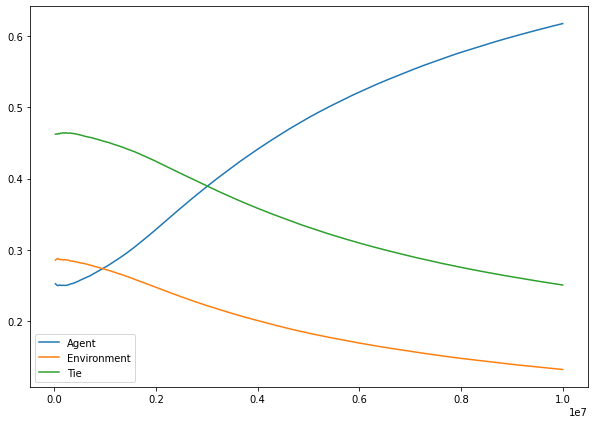

In [75]:
# Check how well the agent performs over time

np.seterr(divide='ignore', invalid='ignore')

winnings = np.array(winnings_track)
xrange = np.arange(0, 10000001, 20000)

plt.figure(0, figsize=(10, 7))

plt.plot(xrange, winnings[:, 0]/xrange)
plt.plot(xrange, winnings[:, 1]/xrange)
plt.plot(xrange, winnings[:, 2]/xrange)
plt.legend(["Agent", "Environment", "Tie"], loc="lower left")

The graph depicts how well the Agent and the Environment performed during the initial set of episodes, with both winning roughly the same number of games. Each has a 27 percent chance of winning and a 46 percent chance of tie.

Gradually, the agent's performance improved, and by the end of the final set of episodes, the agent had won 62 percent of the game with a 25 percent tie, leaving the environment with only 13 percent.

#### Check the Q-dictionary

In [34]:
len(Q_dict)

4310489

In [41]:
Q_dict['4-x-6-x-7-x-x-9-x']

{(1, 1): -0.05,
 (1, 3): 0,
 (1, 5): 5.598733313482343,
 (3, 1): -0.05,
 (3, 3): 0,
 (3, 5): -0.0975,
 (5, 1): -0.05,
 (5, 3): -0.05,
 (5, 5): 0,
 (6, 1): -0.037500000000000006,
 (6, 3): -0.0975,
 (6, 5): 0,
 (8, 1): 0,
 (8, 3): -0.05,
 (8, 5): -0.05}

In [65]:
env = TicTacToe()
def check_win(state):
    board = [int(x) if x!='x' else 0 for x in state.split('-')]
    env.show_board(board)
    won = env.is_winning(board)
    print("Won the game:",won)

Examine the agent's ability to take appropriate action in a given state.

In [66]:
state = '4-x-6-x-7-x-x-9-x'
print("Current Board State")
check_win(state)
print('*'*20)
action = max(Q_dict[state],key=Q_dict[state].get)
print("action:", action) 
print("Next Board State")
next_state = '4-5-6-x-7-x-x-9-x'
check_win(next_state)

Current Board State
------------
|4|~|6|
------------
|~|7|~|
------------
|~|9|~|
------------
Won the game: False
********************
action: (1, 5)
Next Board State
------------
|4|5|6|
------------
|~|7|~|
------------
|~|9|~|
------------
Won the game: True


#### Check the states tracked for Q-values convergence
(non-evaluative)

In [36]:
def plot_qvalue_convergence(state, action):
    q_values = states_track[state][action]
    plt.plot(range(0, len(q_values)), q_values)
    plt.ylabel("Q_value")
    plt.title("State : "+state+" | Action : "+str(action))
    plt.legend(["Q-value"], loc="lower left")

<Figure size 1440x1080 with 0 Axes>

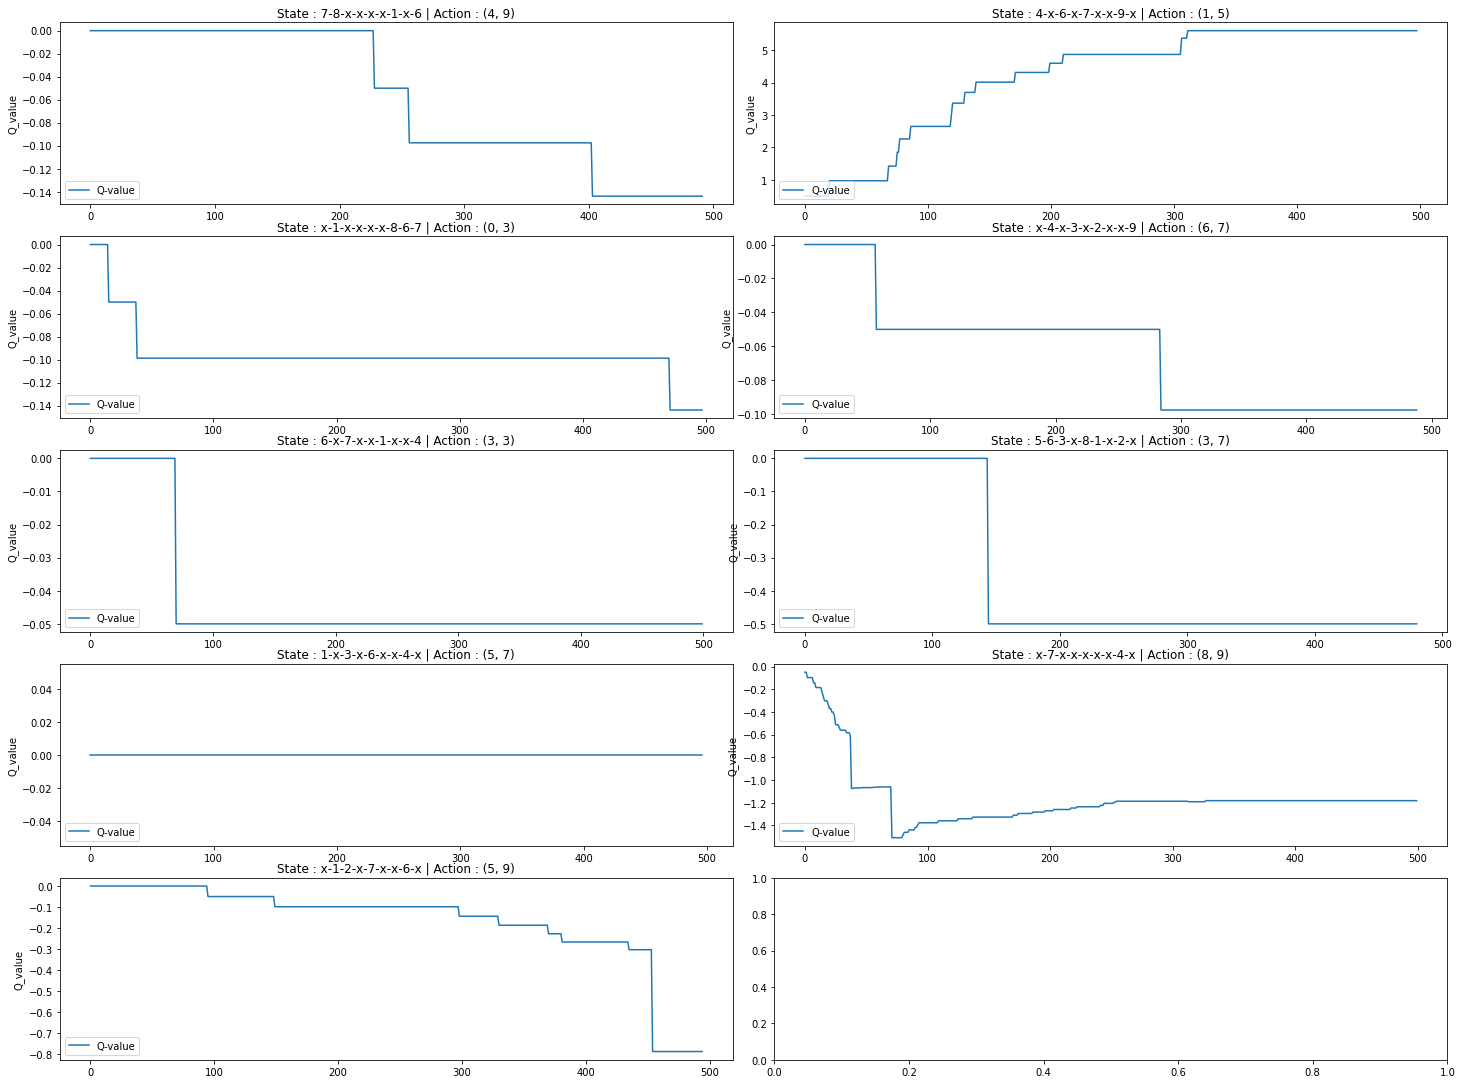

In [37]:
plt.figure(0, figsize=(20, 15))
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))
fig.tight_layout()
idx = 1
for state in states_track.keys():
    for action in states_track[state].keys():
        plt.subplot(5, 2, idx)
        plot_qvalue_convergence(state, action)
        idx+=1
plt.show()

The plot above depicts how well the Q-value converges for the given state and action pair.

### Epsilon - decay check

<Figure size 1440x504 with 0 Axes>

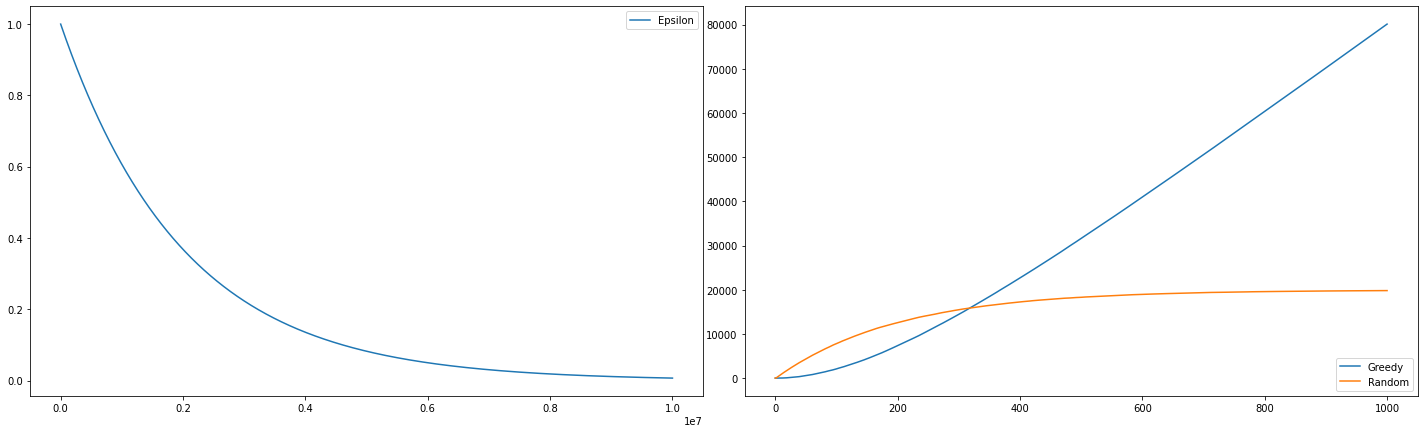

In [57]:
greedy_action_track = {'greedy':[0], 'random':[0]}
greedy_random_count = [0, 0]
episodes = 10000000
epsilons = []
ACTION_CHECKPOINT = episodes/1000

def epsilon_greedy(episode, emax=1.0, emin=0.0001):
    epsilon = emin + (emax - emin) * np.exp(-0.0000005 * episode)
    z = np.random.random()
    if z > epsilon:
        greedy_random_count[0]+=1
    else:
        greedy_random_count[1]+=1
    return epsilon

for episode in range(0, episodes, 100):
    epsilons.append(epsilon_greedy(episode))
    if episode%ACTION_CHECKPOINT == 0:
        greedy_action_track['greedy'].append(greedy_random_count[0])
        greedy_action_track['random'].append(greedy_random_count[1])
        
plt.figure(0, figsize=(20, 7))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, episodes, 100), epsilons)
plt.legend(["Epsilon"], loc="upper right")
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 1001), greedy_action_track['greedy'])
plt.plot(np.arange(0, 1001), greedy_action_track['random'])
plt.legend(["Greedy", "Random"], loc="lower right")
plt.show()